# An analytical theory of firm selection 

This notebook solves the maximisation problem of a firm with access to a risky technology. The firm has access to a production technology that is stochastic and has an exogenous probability of default. The firm chooses the optimal level of debt and labor input given the interest rate and the probability of default. 

The production technology is Cobb-Douglas: 

$$Y = z * \epsilon * l^\alpha$$

where $Y$ is the output, $z$ is the permanent productivity, $\epsilon$ is a shock with log-normal distribution, l$$ is the labor input and $alpha$ is the Cobb-Douglas exponent.  

The firm has some net worth $n$, and must pay its workers wages $w*l$, so that its borrowings are defined as $d = w*l - n$. The firm can borrow some cash $d$ from a bank at a rate $\tilde{r}$, and profits are given by: 
$$\pi= z\epsilon l^\alpha - \tilde{r}d$$

The firm will default if the profits are less than the borrowings, i.e. if: 
$$z\epsilon l^\alpha - \tilde{r}d < 0$$

The bank will charge an interest rate $\tilde{r}$ that depends on the probability of default. The probability of default is given by the integral of the probability of the shock being less than the borrowing. 

The maximisation problem can be written as: 

$$\begin{aligned}
& \max _{\{l, d\}} \mathbb{E}_\epsilon \max \left\{z \epsilon l^\alpha-\tilde{r} d, 0\right\} \\
\text { s.t. } & (1-H(\bar{e})) \tilde{r} d+(1-\mu) \int_0^{\bar{\varepsilon}} z \epsilon l^\alpha \mathrm{d} H(\epsilon) \geq r d \\
& d=w l-n \\
& z \bar{e} l^\alpha-\tilde{r} d=0
\end{aligned}$$

We first define the parameters with a grid on $z$ and $\epsilon$. 

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_hermite
from scipy import optimize

# Permanent productivity
z_min = 0.8
z_max = 2
nZ = 10
z_grid = np.linspace(z_min, z_max, nZ)

# Shock
mu = 0.0       # Mean of ln(epsilon)
sigma = 0.3    # Standard deviation of ln(epsilon)

nE = 100
nodes, weights = roots_hermite(nE)
e_grid = np.exp(np.sqrt(2) * sigma * nodes + mu)
e_prob = weights / np.sqrt(np.pi)
e_cdf = np.cumsum(e_prob)

# Precompute cumulative sums for interpolation
profits_cumsum_base = np.cumsum(e_prob * e_grid)
profits_cumsum_base = profits_cumsum_base  # Ensure it's an array

# Parameters
mu = 0.95
w = 1
alpha = 1/2
n = 0.01
r = 1.05
z = 1 

/var/folders/y9/jg30tbps6k92mh06j253lf200000gn/T/ipykernel_15041/4189568308.py:3: RuntimeWarning: divide by zero encountered in divide
  r_tilde = (z * epsilon_bar * l**alpha) / d
/var/folders/y9/jg30tbps6k92mh06j253lf200000gn/T/ipykernel_15041/4189568308.py:6: RuntimeWarning: invalid value encountered in multiply
  bank_error = (1 - default_probability) * r_tilde * d + (1-mu) * default_probability * expected_profits - r * d


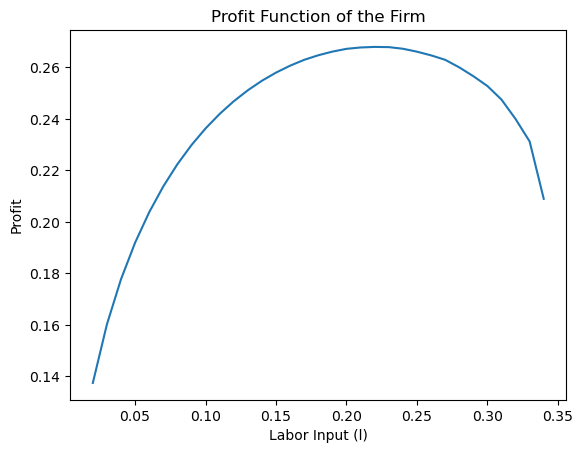

In [11]:
def default_probability_obj(epsilon_bar, l, z, alpha, w, n, r): 
    d = w * l - n 
    r_tilde = (z * epsilon_bar * l**alpha) / d 
    default_probability = np.interp(epsilon_bar, e_grid, e_cdf)
    expected_profits = l**alpha * np.interp(epsilon_bar, e_grid, profits_cumsum_base)
    bank_error = (1 - default_probability) * r_tilde * d + (1-mu) * default_probability * expected_profits - r * d
    return bank_error

def profits(l, z, alpha, w, n, r):
    d = w * l - n 
    res = optimize.root(default_probability_obj, 0.5, args=(l, z, alpha, w, n, r), method='hybr')
    if res.success == False: 
        return np.inf 
    epsilon_bar = res.x[0]
    r_tilde = (z * epsilon_bar * l**alpha) / d 
    profits_temp = z * e_grid * l**alpha - r_tilde * d
    profits = np.sum(e_prob * np.maximum(profits_temp, 0))
    return -profits

def find_max_l(z, alpha, w, n, r):
    l_grid = np.linspace(0.01, 10, 1000)
    profits_grid = profits_vec(l_grid, z, alpha, w, n, r)
    # Find the index of the first value that is equal to inf
    inf_index = np.where(np.isinf(profits_grid))[0]
    if len(inf_index) > 0:
        l_max = l_grid[inf_index[0] - 1]  # Use the last valid value before inf
    
    l_grid = np.linspace(0.01, l_max, 1000)
    return l_grid

profits_vec = np.vectorize(profits, excluded=['z', 'alpha', 'w', 'n', 'r'])

l_grid = find_max_l(z, alpha, w, n, r)
profits_grid = profits_vec(l_grid, z, alpha, w, n, r)
plt.plot(l_grid, -profits_grid)
plt.xlabel('Labor Input (l)')
plt.ylabel('Profit')
plt.title('Profit Function of the Firm')
plt.show()

/var/folders/y9/jg30tbps6k92mh06j253lf200000gn/T/ipykernel_15041/4189568308.py:3: RuntimeWarning: divide by zero encountered in divide
  r_tilde = (z * epsilon_bar * l**alpha) / d
/var/folders/y9/jg30tbps6k92mh06j253lf200000gn/T/ipykernel_15041/4189568308.py:6: RuntimeWarning: invalid value encountered in multiply
  bank_error = (1 - default_probability) * r_tilde * d + (1-mu) * default_probability * expected_profits - r * d


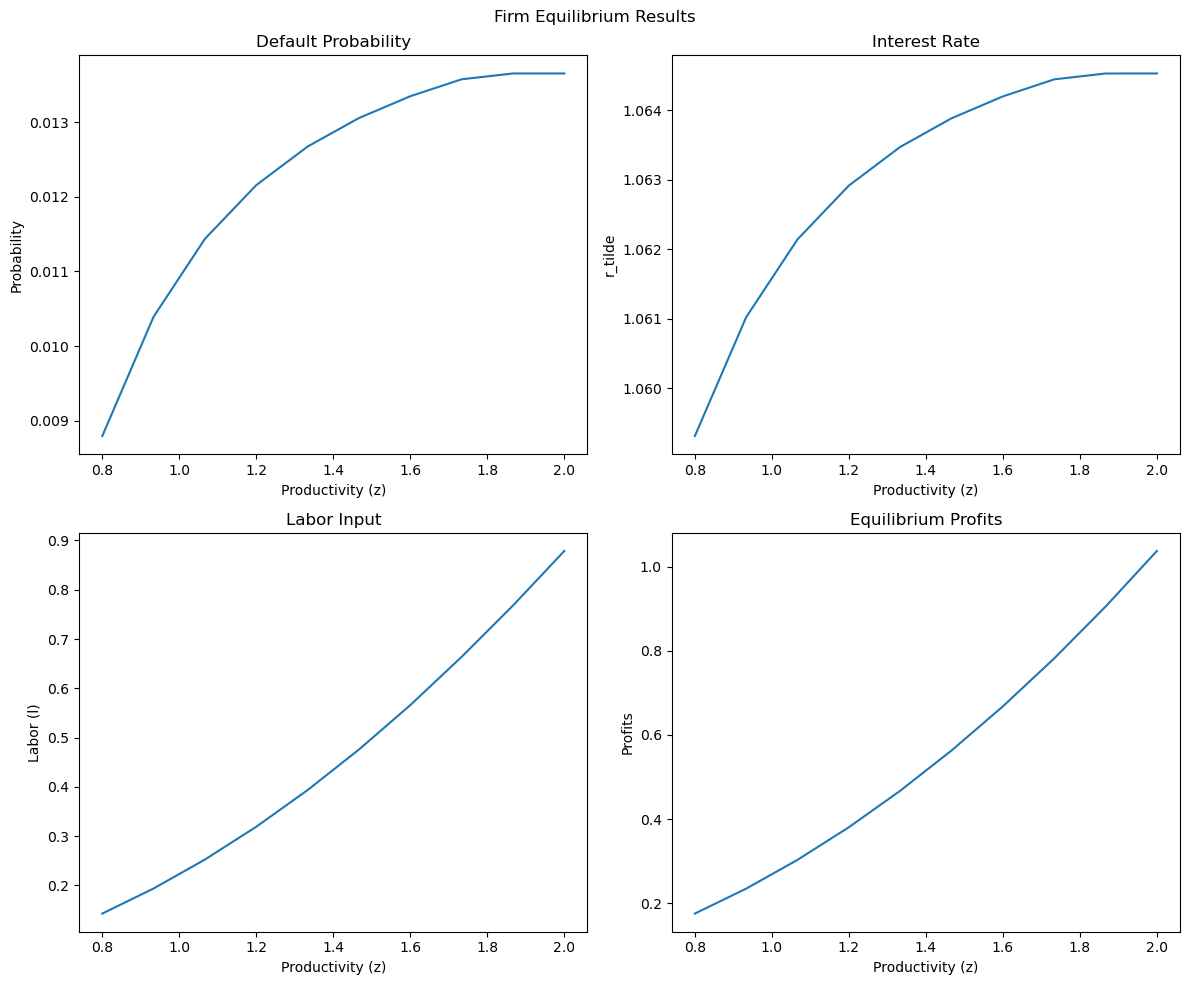

In [12]:
def golden_section_search(f, a, b, tol=1e-5, args=()):

    gr = (np.sqrt(5) + 1) / 2  # golden ratio

    # Initialize points
    c = b - (b - a) / gr
    d = a + (b - a) / gr

    while abs(b - a) > tol:
        if f(c, *args) < f(d, *args):
            b = d
        else:
            a = c

        # Update the points
        c = b - (b - a) / gr
        d = a + (b - a) / gr

    x_min = (b + a) / 2
    f_min = f(x_min, *args)
    
    return x_min, f_min

def get_eq_default_prob(z, alpha, w, n, r):
    
    l_grid = find_max_l(z, alpha, w, n, r)
    profits_grid = profits_vec(l_grid, z, alpha, w, n, r)
    l_opt = np.argmin(profits_grid)
    l = l_grid[l_opt]
    
    l, f_min = golden_section_search(profits, l * 0.9, l * 1.1, args=(z, alpha, w, n, r))
    """ 
    res = optimize.minimize(profits, x0 = l, args = (z, alpha, w, n, r))   
    
    if res.success == False: 
        print("Didn't find an optimum for z  =", z)
    l = res.x[0]
    """
    
    res = optimize.root(default_probability_obj, 0.5, args=(l, z, alpha, w, n, r), method='hybr') 
    if res.success == False: 
        print("Didn't find an equilibrium epsilon_bar for z  =", z)
    epsilon_bar = res.x[0]
    d = w * l - n 
    r_tilde = (z * epsilon_bar * l**alpha) / d 
    default_probability = np.interp(epsilon_bar, e_grid, e_cdf)
    
    return r_tilde, default_probability, l, -profits(l, z, alpha, w, n, r)

r_tilde = np.zeros((nZ))
default_probability  = np.zeros((nZ))
l_opt = np.zeros((nZ))
profits_eq = np.zeros((nZ))
for iz, z in enumerate(z_grid):
    r_tilde[iz], default_probability[iz], l_opt[iz], profits_eq[iz] = get_eq_default_prob(z, alpha, w, n, r)


fig, axs = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Firm Equilibrium Results')

axs[0, 0].plot(z_grid, default_probability)
axs[0, 0].set_title('Default Probability')
axs[0, 0].set_xlabel('Productivity (z)')
axs[0, 0].set_ylabel('Probability')

axs[0, 1].plot(z_grid, r_tilde)
axs[0, 1].set_title('Interest Rate')
axs[0, 1].set_xlabel('Productivity (z)')
axs[0, 1].set_ylabel('r_tilde')

axs[1, 0].plot(z_grid, l_opt)
axs[1, 0].set_title('Labor Input')
axs[1, 0].set_xlabel('Productivity (z)')
axs[1, 0].set_ylabel('Labor (l)')

axs[1, 1].plot(z_grid, profits_eq)
axs[1, 1].set_title('Equilibrium Profits')
axs[1, 1].set_xlabel('Productivity (z)')
axs[1, 1].set_ylabel('Profits')

plt.tight_layout()
plt.show()
